# Brain Tumor Classification

## Introduction

Brain tumors are formed when abnormal cells appear within the brain. These are among the most dangerous diseases and require urgent action in the early stages. The best technique to detect tumors is Magnetic Resonance Imaging (MRI). The captured images should then be examined by a neurologist. However, automated classification techniques can be used to improve the accuracy of these classifications.

In this task, we are using a dataset from Kaggle that contains 3,264 images of MRI data in four categories: glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor. The dataset has already been split into Train and Test sets. Our goal is to build a neural network that predicts whether a person has a tumor, and if so, identifies its type.

## Importing Libraries

In [1]:
import time
import random
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import visualkeras
from PIL import ImageFont, Image
import warnings 
warnings.filterwarnings('ignore')

## Loading Data

Since our labels are categorical we have to convert them into numerical representation. 

In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3}

inverse_class_map = {
    0: 'no_tumor',
    1: 'glioma_tumor',
    2: 'meningioma_tumor',
    3: 'pituitary_tumor'}

In [3]:
Train_images = []
Train_Lables = []
Test_images = []
Test_Lables = []

for label in labels:
    folderPath = os.path.join('Training/', label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(224, 224))
        Train_images .append(img)
        Train_Lables.append(class_map[label])
          
        
for label in labels:
    folderPath = os.path.join('Testing/', label)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(224, 224))
        Test_images.append(img)
        Test_Lables.append(class_map[label])

X_train = np.array(Train_images)
y_train = np.array(Train_Lables)

X_test = np.array(Test_images)
y_test = np.array(Test_Lables)

100%|██████████| 74/74 [00:01<00:00, 53.61it/s]


## EDA

In [4]:
print("X_train dimension:", X_train.shape)
print("y_train dimension:",y_train.shape)

print("X_test dimension:", X_test.shape)
print("y_test dimension:",y_test.shape)

X_train dimension: (2870, 224, 224, 3)
y_train dimension: (2870,)
X_test dimension: (394, 224, 224, 3)
y_test dimension: (394,)


We have 2,870 images in our training set and 394 images in our test set. These images have dimensions of 224×224 with 3 channels (RGB).

Then we divide our training set into training and validation subsets.

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

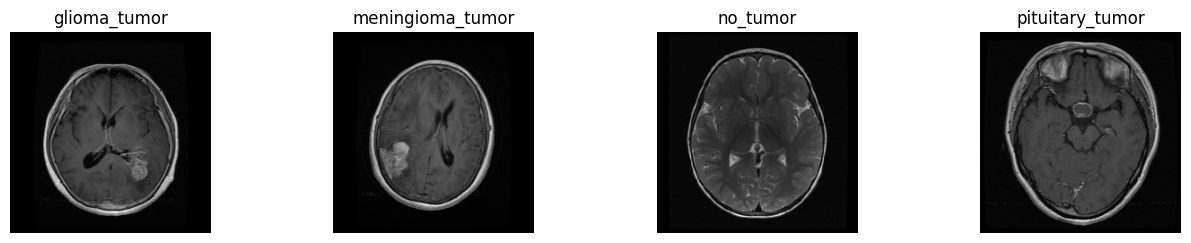

In [6]:
plt.figure(figsize=(16, 12))

path = 'Training/'
fileNames = ['glioma_tumor/gg (10).jpg', 'meningioma_tumor/m (108).jpg', 'no_tumor/image (16).jpg', 'pituitary_tumor/p (12).jpg']
fileLabels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for i in range(4):
    ax = plt.subplot(4, 4, i + 1)
    img = mpimg.imread(path + fileNames[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

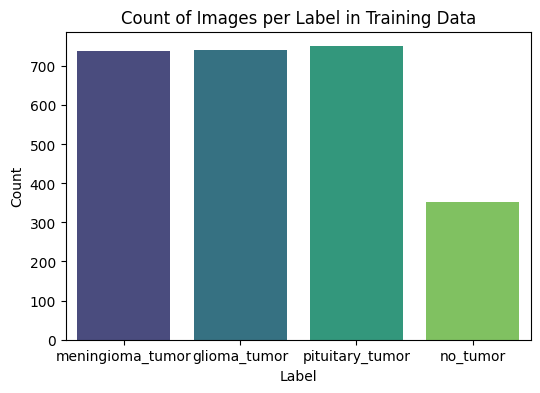

In [7]:
train_labels_df = pd.DataFrame({'Labels': y_train})

train_labels_df['Labels'] = train_labels_df['Labels'].map(inverse_class_map)

plt.figure(figsize=(6, 4))
sns.countplot(x='Labels', data=train_labels_df, palette='viridis')
plt.title('Count of Images per Label in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


From the above figure, we can understand that, with a good approximation, our dataset is balanced.

## Model

In this section, we build different CNN models, which are among the best and most suitable models for image classification. We start with a very simple architecture and then attempt to design a more complex model to observe whether it leads to any improvements.
Since we want to compare our models we use a function to train our model and store the result.

In [11]:
results = []

# a function to train a model and store results
def train_and_evaluate_model(model, X_train, y_train, X_validation, y_validation, X_test, y_test, model_name, data_generator=None, epochs=15, batch_size=32, callbacks=None):
    start_time = time.time()
    
    if data_generator:
        history = model.fit(
            data_generator.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_validation, y_validation),
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_validation, y_validation),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
    
    end_time = time.time()
    training_time = end_time - start_time
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_accuracy:.2f}")
    
    # Append results to the table
    results.append({
        'Model': model_name,
        'Validation Accuracy': max(history.history['val_accuracy']),
        'Test Accuracy': test_accuracy,
        'Training Time (s)': training_time
    })

### 1. Simplified CNN

In this network, we have 5 layers:
1. Conv2D: A convolutional layer with 32 filters and a window size of 3x3. We use ReLU as the activation function to introduces non-linearity.
2. MaxPooling2D: Reduces spatial dimensions by downsampling feature maps with a 2x2 pooling window.
3. Flatten Layer: Converts the 2D feature maps into a 1D vector for input to dense layers.
4. Dense Layer 1: A fully connected layer with 64 neurons. We use ReLU as the activation function to learn the complexity of patterns.
5. Dense Layer 2 (Output Layer): A fully connected layer with 4 neurons (one for each class) and softmax activation for multi-class probability distribution.
Additionally, we include a Dropout layer that randomly drops 50% of neurons during training to prevent overfitting.

In [12]:
model_simple = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')])


model_simple.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_and_evaluate_model(model_simple, X_train, y_train, X_validation, y_validation, X_test, y_test, "Simplified CNN")

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.3089 - loss: 476.3629 - val_accuracy: 0.2892 - val_loss: 1.3809
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.2963 - loss: 1.3775 - val_accuracy: 0.2892 - val_loss: 1.3744
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.2864 - loss: 1.3742 - val_accuracy: 0.2892 - val_loss: 1.3694
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 270ms/step - accuracy: 0.2863 - loss: 1.3667 - val_accuracy: 0.2892 - val_loss: 1.3659
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.2714 - loss: 1.3585 - val_accuracy: 0.2648 - val_loss: 1.3633
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.2722 - loss: 1.3541 - val_accuracy: 0.2648 - val_loss: 1.3615
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.2931 - loss: 1.3519 - val_accuracy: 0.2648 - val_loss: 1.3603
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.3053 - loss: 1.3482 - val_ac

In [13]:
model_simple.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,703,886 (288.79 MB)

 Trainable params: 25,234,628 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,469,258 (192.52 MB)

### 2. Another CNN

In this session we are going to add more layers to our network to build more complicated model.
Similar to the previous architecture, our input layer is Conv2D. After that, we include Batch Normalization to normalize the outputs of the previous layer. Then, we use MaxPooling2D to reduce the spatial dimensions of the features. This structure is repeated twice to allow the network to capture more complex patterns. Next, we convert the 3D features from the last layer into a 1D vector using Flatten. Finally, we have two dense layers to produce our final output.

In [14]:
model_improved = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')])

model_improved.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

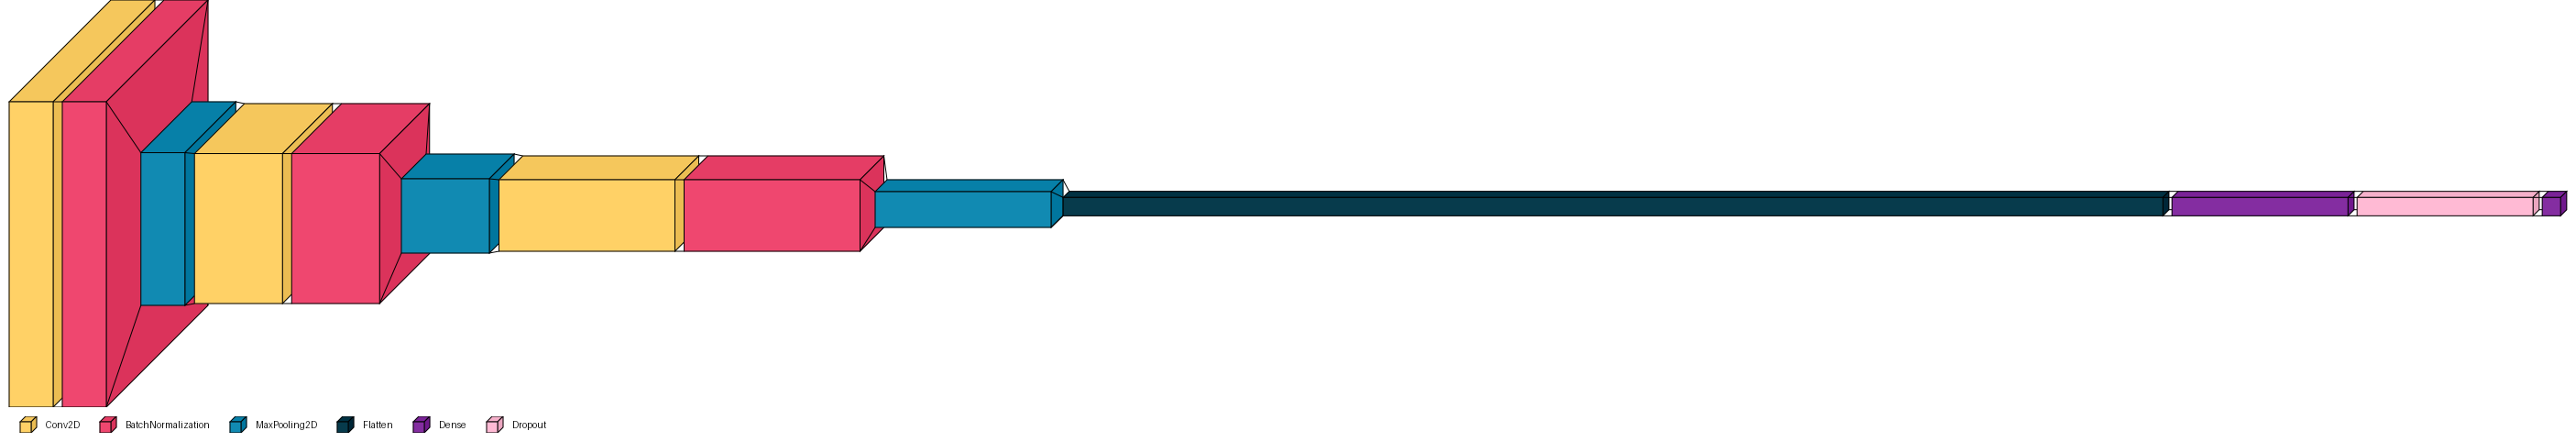

In [15]:
visualkeras.layered_view(model_improved,legend=True, scale_xy=1.5, scale_z=1.5, max_z=1200)

In [17]:
model_improved.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_and_evaluate_model(model_improved, X_train, y_train, X_validation, y_validation, X_test, y_test, "Improved CNN")

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 954ms/step - accuracy: 0.5937 - loss: 0.9386 - val_accuracy: 0.7422 - val_loss: 1.0046
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 895ms/step - accuracy: 0.6148 - loss: 1.0364 - val_accuracy: 0.7178 - val_loss: 0.8031
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 844ms/step - accuracy: 0.6224 - loss: 0.9243 - val_accuracy: 0.6202 - val_loss: 1.1879
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 847ms/step - accuracy: 0.6203 - loss: 0.9466 - val_accuracy: 0.5296 - val_loss: 1.6811
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 840ms/step - accuracy: 0.6384 - loss: 0.7978 - val_accuracy: 0.7456 - val_loss: 0.7182
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 834ms/step - accuracy: 0.6753 - loss: 0.7436 - val_accuracy: 0.6481 - val_loss: 0.7853
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 847ms/step - accuracy: 0.6480 - loss: 0.7791 - val_accuracy: 0.7143 - val_loss: 0.8086
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 828ms/step - accuracy: 0.6828 - loss: 0.7392 - val_accu

## L2 Regularization + Early Stopping

In this part, we add two additional parameters to our model:  

1. L2 Regularization, to penalize large weights, thereby reducing overfitting.  
2. Early Stopping, which monitors validation performance and stops training when there is no further improvement.  


In [18]:
model_l2_es = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
model_l2_es.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
train_and_evaluate_model(model_l2_es, X_train, y_train, X_validation, y_validation, X_test, y_test, "L2 Regularization + Early Stopping", callbacks=[early_stopping], epochs=50)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 74s 854ms/step - accuracy: 0.4039 - loss: 9.8431 - val_accuracy: 0.1707 - val_loss: 6.2570
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 852ms/step - accuracy: 0.4727 - loss: 2.0052 - val_accuracy: 0.2439 - val_loss: 2.8679
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 850ms/step - accuracy: 0.3781 - loss: 2.0151 - val_accuracy: 0.3519 - val_loss: 2.2045
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 845ms/step - accuracy: 0.3444 - loss: 2.0329 - val_accuracy: 0.2892 - val_loss: 9.9155
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 848ms/step - accuracy: 0.3719 - loss: 1.9186 - val_accuracy: 0.5331 - val_loss: 1.7333
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 848ms/step - accuracy: 0.4199 - loss: 1.8250 - val_accuracy: 0.5854 - val_loss: 1.6429
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 853ms/step - accuracy: 0.4654 - loss: 1.7529 - val_accuracy: 0.4704 - val_loss: 1.7046
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 850ms/step - accuracy: 0.4670 - loss: 1.7678 - val_accu

## Data Augmentation

We can also increase our training set by adding new data to assist the model learn more patterns from unseen data. Here, we apply the following transformations: rotating images by 20 degrees, shifting them horizontally and vertically, applying shear and zoom transformations, flipping images horizontally, and filling pixels for image shifts.

In [19]:
model_improved.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')
datagen.fit(X_train)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model 
train_and_evaluate_model( model_improved, X_train, y_train, X_validation, y_validation, X_test, y_test, model_name="Data Augmentation", 
                         data_generator=datagen, callbacks=[early_stopping], epochs=60)


Epoch 1/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.3590 - loss: 1.9451 - val_accuracy: 0.5331 - val_loss: 1.0275
Epoch 2/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3546 - loss: 1.4695 - val_accuracy: 0.5889 - val_loss: 0.9199
Epoch 3/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4097 - loss: 1.5171 - val_accuracy: 0.4704 - val_loss: 2.4384
Epoch 4/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4015 - loss: 1.4462 - val_accuracy: 0.5923 - val_loss: 0.9366
Epoch 5/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4170 - loss: 1.2593 - val_accuracy: 0.4878 - val_loss: 1.1422
Epoch 6/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.4714 - loss: 1.4257 - val_accuracy: 0.5192 - val_loss: 1.1133
Epoch 7/60
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4435 - loss: 1.2303 - val_accuracy: 0.5714 - val_loss: 0.9972
Data Augmentation - Test Accuracy: 0.32


## Final Model

It is time to decide which of these four models performs better. According to the table below, although our third model achieves the best accuracy (83% for validation), both the third and second models have almost the same performance on the test data. Since the second model requires less time to run, we will use it for hyperparameter tuning in the next section.

In [20]:
results_df = pd.DataFrame(results)
results_df

,Model,Validation Accuracy,Test Accuracy,Training Time (s)
0,Simplified CNN,0.289199,0.192893,380.412348
1,Improved CNN,0.815331,0.484772,1108.353615
2,L2 Regularization + Early Stopping,0.839721,0.456853,1873.233896
3,Data Augmentation,0.592335,0.319797,1024.701626


## Hyperparameter Tuning

We use the Keras Tuner library to tune the hyperparameters of our model. Within it, we define a function to modify the number of filters, dense units, and learning rate. To save time, we utilize RandomSearch for the hyperparameter optimization process.

In [36]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32), 
                     (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))


Trial 5 Complete [00h 18m 55s]
val_accuracy: 0.8362369537353516

Best val_accuracy So Far: 0.8710801601409912
Total elapsed time: 01h 02m 16s


In [37]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [38]:
final_model = tuner.hypermodel.build(best_hps)


# Train the final model
history = final_model.fit( X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, batch_size=32,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], verbose=1)


# Evaluate 
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 302ms/step - accuracy: 0.4963 - loss: 937.9770 - val_accuracy: 0.6551 - val_loss: 8.5281
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.8786 - loss: 1.9579 - val_accuracy: 0.7247 - val_loss: 7.2360
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.9244 - loss: 1.0670 - val_accuracy: 0.8153 - val_loss: 3.8429
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 0.9600 - loss: 0.6948 - val_accuracy: 0.8084 - val_loss: 3.7870
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step - accuracy: 0.9871 - loss: 0.0818 - val_accuracy: 0.8502 - val_loss: 3.2994
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step - accuracy: 0.9953 - loss: 0.0257 - val_accuracy: 0.8293 - val_loss: 3.0330
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - accuracy: 0.9958 - loss: 0.0296 - val_accuracy: 0.8258 - val_loss: 3.1384
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.9966 - loss: 0.0204 - val_ac

In the end, we achieve 64% accuracy on our test set and 85% accuracy on our validation set.

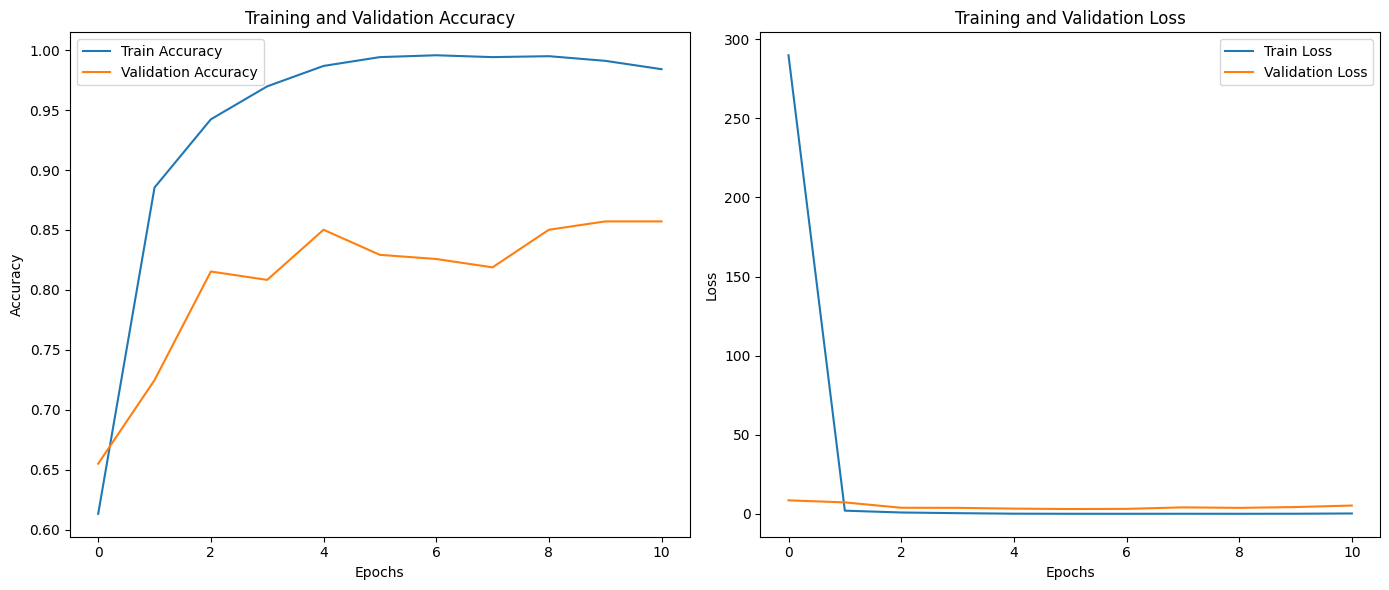

In [39]:
plt.figure(figsize=(14, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  
plt.show()
